In [119]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from data_utils import *
import gpytorch
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.distributions import MultivariateNormal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Load data

In [120]:
# Load a file and inject an anomaly
data_dir = '../data/k2/'
filename = 'k2_77.fits'
fits_file = fits.open(data_dir + filename)

# Load data
data = fits_file[1].data
time = np.array(data['TIME'])
pdc_flux = np.array(data['PDCSAP_FLUX'])
pdc_err = np.array(data['PDCSAP_FLUX_ERR'])

# Set x, y, and error
x = time
y = pdc_flux / np.nanmedian(pdc_flux)
y_err = pdc_err / np.nanmedian(pdc_flux)

# Clean
clean = (y_err > 0.)
x = x[clean]
y = y[clean]
y_err = np.abs(y_err[clean]) 

# Shift to start at time 0
x = x - np.min(x) 

# Bin to 30-minute cadence
num_bins = int(np.floor((np.max(x) - np.min(x)) * 48) + 1) # 48 bins per day
x_bins = np.min(x) + np.arange(num_bins + 1) / 48.
num_binned, bin_edges = np.histogram(x, bins= x_bins)
num_binned = np.array(num_binned)
y_binned, bin_edges = np.histogram(x, bins = x_bins, weights = y)
var_binned, bin_edges = np.histogram(x, bins = x_bins, weights= 1 / y_err**2)
y_err_binned = 1 / np.sqrt(np.array(var_binned))
y_binned = np.array(y_binned)
y_binned = y_binned / (num_binned + 0.001)
x_binned = x_bins[0:num_bins] + (x_bins[1] - x_bins[0]) / 2. 
x = x_binned
y = y_binned
y_err = y_err_binned

# Clean
clean = ((y > 0.) & ~np.isnan(y_err))
x = x[clean]
y = y[clean]
y_err = y_err[clean]

assert len(x) == len(y) == len(y_err), 'Lengths of x, y, and y_err must be the same'

/tmp/ipykernel_1050394/2834843138.py:33: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


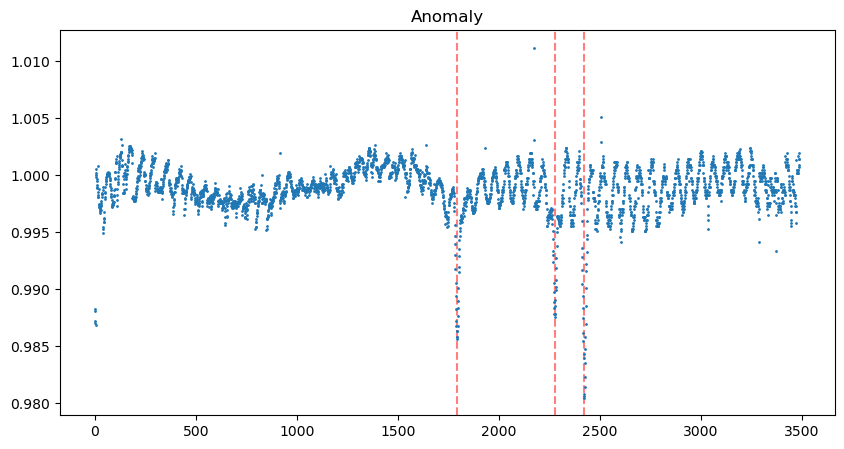

In [121]:
# Inject anomalies
steps, y, anomaly_locs = inject_anomaly(y, num_anomalies=3, seed=48)

# TODO: scale? Causing numerical issues but maybe would be useful

# Convert to tensors
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
y_err_tensor = torch.tensor(y_err, dtype=torch.float32).to(device)

# Plot
plt.figure(figsize=(10,5))
for i in range(len(anomaly_locs)):
    plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5)
plt.plot(steps, y, '.', markersize=2)
plt.title("Anomaly")
plt.show()

# Anomaly detection with GP
### Method:
1. Perform GP regression on the timeseries.
2. Find the most significant outlier point.
3. Exclude that point and redo regression. See if GP improves by some threshold.
4. Exclude adjacent points and redo step 3.
5. Repeat step 4 as long as GP improves the fit by some threshold.
6. If no improvement, define anomaly signal as the difference between data and regression in that interval of points.
7. Repeat steps 2-6 for a defined number of anomalies.

In [115]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [116]:
# Function to train GP model
def train_gp(x_train, y_train, y_err_train, training_iterations=50, device=torch.device("cpu")):
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=y_err_train**2).to(device)
    model = ExactGPModel(x_train, y_train, likelihood).to(device)
    
    # Find optimal hyperparameters
    model.train()
    likelihood.train()

    # Set optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Training loop
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(x_train)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()
    
    return model, likelihood, mll

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(



 New dip identified at anomalous index 2423, x[index] = 53.61458333333333
Old ln-likelihood: -1000000.00000
New ln-likelihood: 3.66719
Difference in ln-likelihood: 1000003.66719
Anomaly index 0, left_edge:right_edge 2422:2423


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


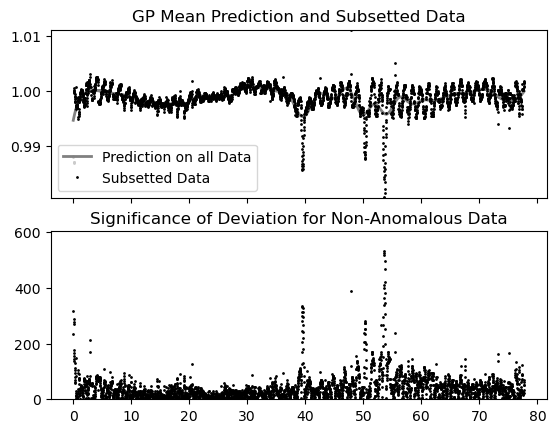

Old ln-likelihood: 3.66719
New ln-likelihood: 3.66681
Difference in ln-likelihood: -0.00038
Anomaly index 0, left_edge:right_edge 2422:2424


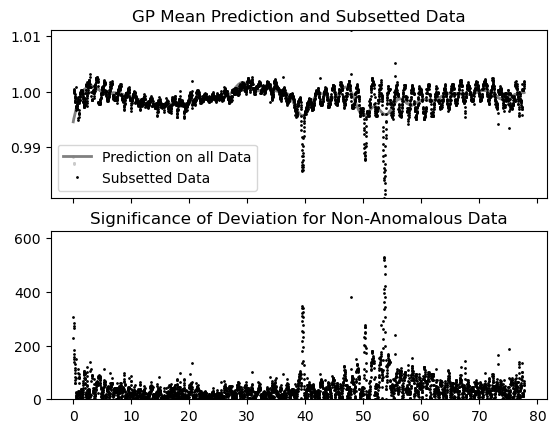

Old ln-likelihood: 3.66681
New ln-likelihood: 3.66722
Difference in ln-likelihood: 0.00041
Anomaly index 0, left_edge:right_edge 2421:2424


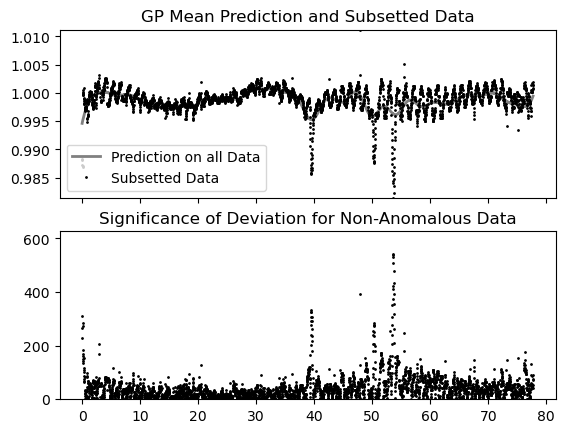

Old ln-likelihood: 3.66722
New ln-likelihood: 3.66740
Difference in ln-likelihood: 0.00017
Anomaly index 0, left_edge:right_edge 2421:2425


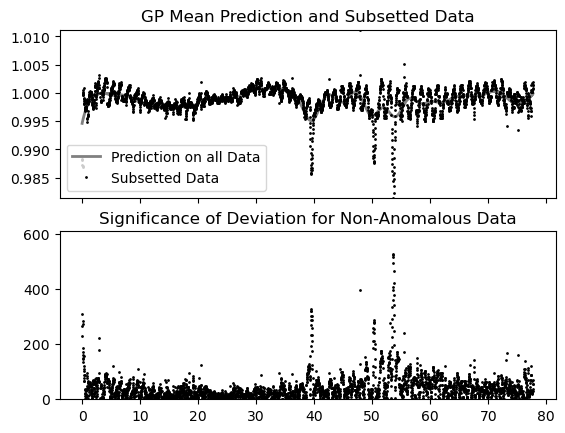

Old ln-likelihood: 3.66740
New ln-likelihood: 3.66770
Difference in ln-likelihood: 0.00030
Anomaly index 0, left_edge:right_edge 2420:2425


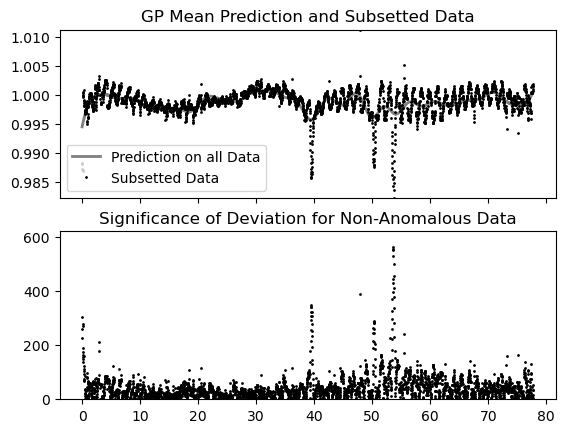

Old ln-likelihood: 3.66770
New ln-likelihood: 3.66750
Difference in ln-likelihood: -0.00019
Anomaly index 0, left_edge:right_edge 2420:2426


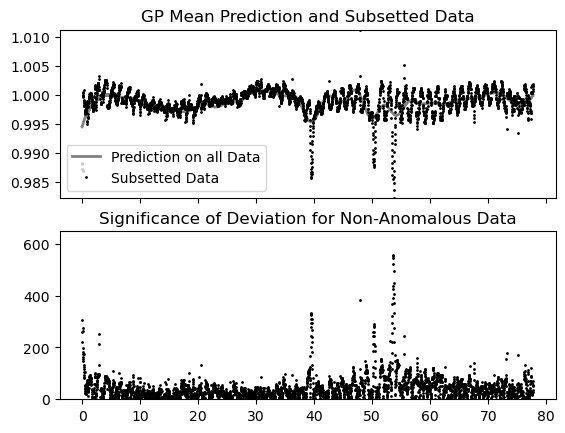

Old ln-likelihood: 3.66750
New ln-likelihood: 3.66841
Difference in ln-likelihood: 0.00090
Anomaly index 0, left_edge:right_edge 2419:2426


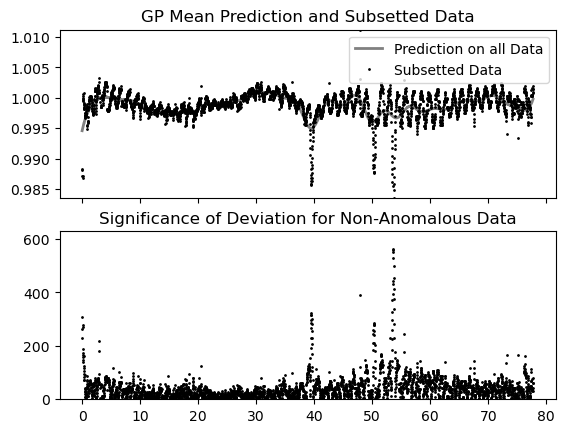

Old ln-likelihood: 3.66841
New ln-likelihood: 3.66813
Difference in ln-likelihood: -0.00027
Anomaly index 0, left_edge:right_edge 2419:2427


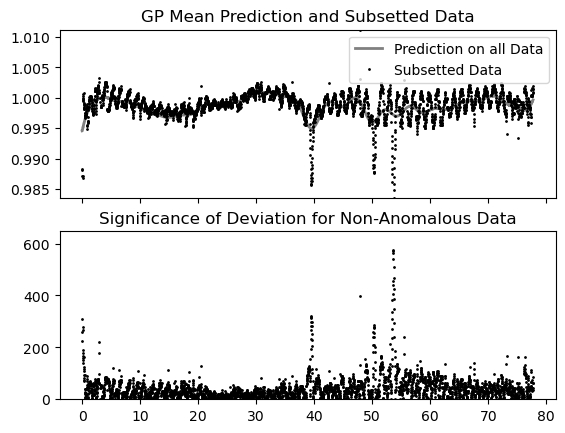

Old ln-likelihood: 3.66813
New ln-likelihood: 3.66869
Difference in ln-likelihood: 0.00055
Anomaly index 0, left_edge:right_edge 2418:2427


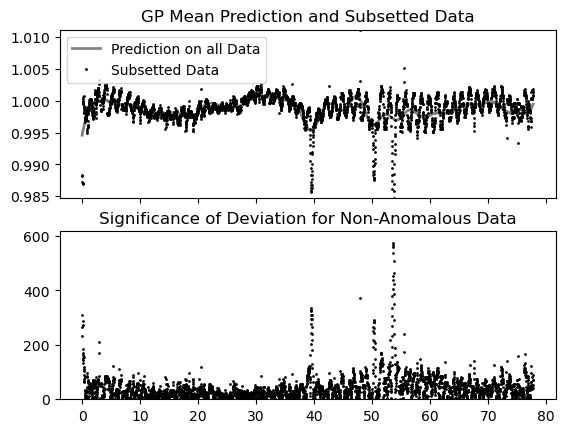

Old ln-likelihood: 3.66869
New ln-likelihood: 3.66870
Difference in ln-likelihood: 0.00002
Anomaly index 0, left_edge:right_edge 2418:2428


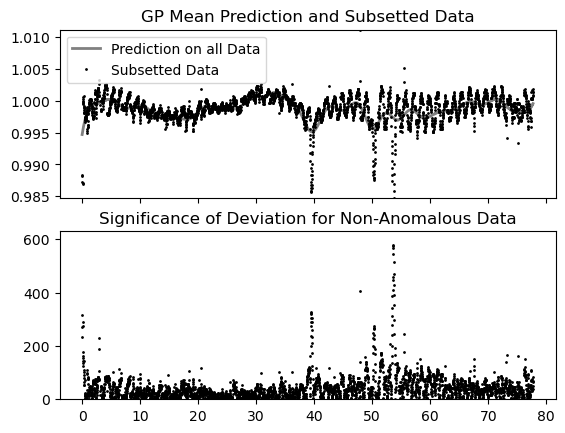

Old ln-likelihood: 3.66870
New ln-likelihood: 3.66864
Difference in ln-likelihood: -0.00006
Anomaly index 0, left_edge:right_edge 2417:2428


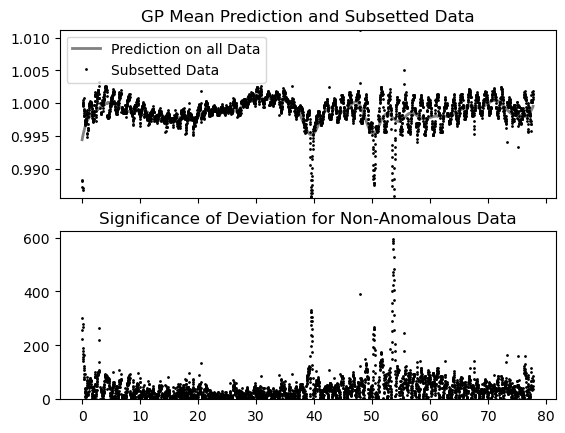

Old ln-likelihood: 3.66864
New ln-likelihood: 3.66895
Difference in ln-likelihood: 0.00031
Anomaly index 0, left_edge:right_edge 2417:2429


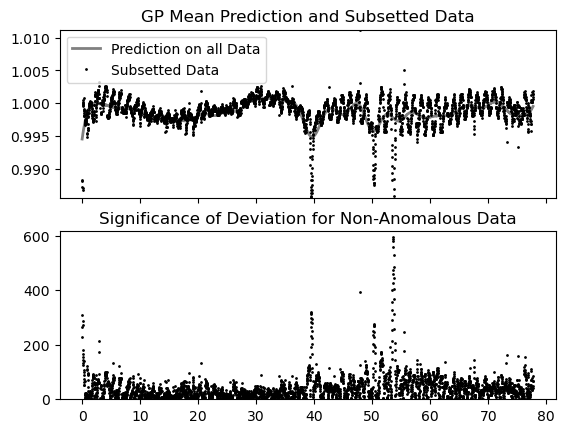

Old ln-likelihood: 3.66895
New ln-likelihood: 3.66974
Difference in ln-likelihood: 0.00079
Anomaly index 0, left_edge:right_edge 2416:2429


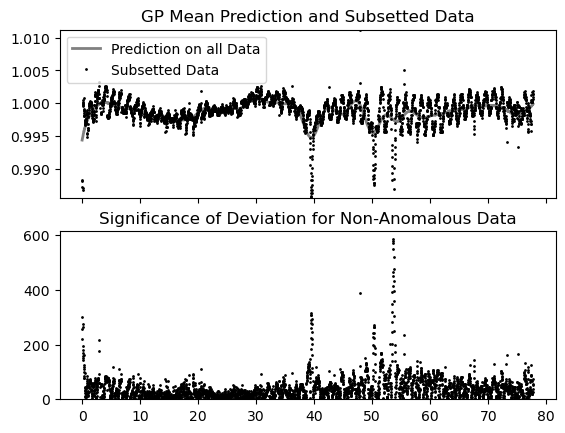

Old ln-likelihood: 3.66974
New ln-likelihood: 3.66912
Difference in ln-likelihood: -0.00062
Anomaly index 0, left_edge:right_edge 2416:2430


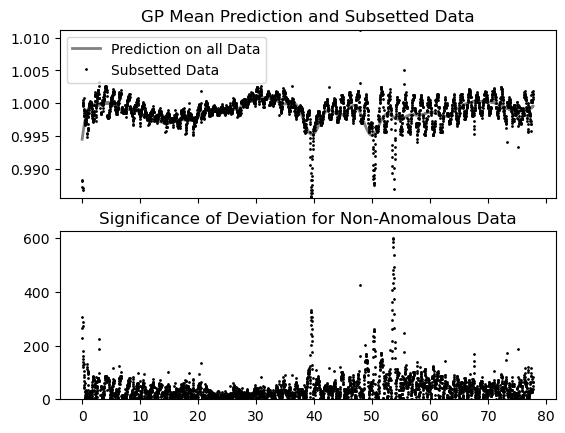


 New dip identified at anomalous index 2416, x[index] = 53.447916666666664
Old ln-likelihood: -1000000.00000
New ln-likelihood: 3.67013
Difference in ln-likelihood: 1000003.67013
Anomaly index 1, left_edge:right_edge 2415:2416


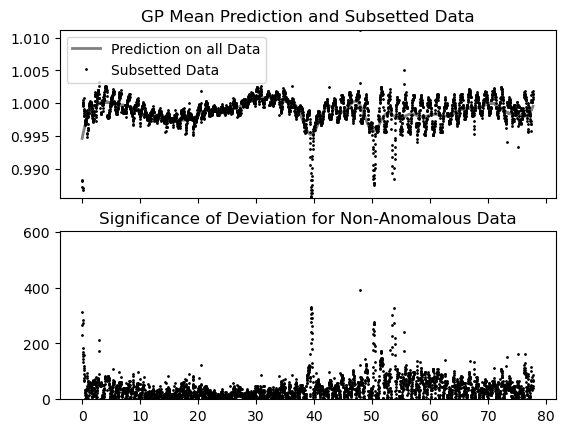

Old ln-likelihood: 3.67013
New ln-likelihood: 3.66953
Difference in ln-likelihood: -0.00060
Anomaly index 1, left_edge:right_edge 2415:2417


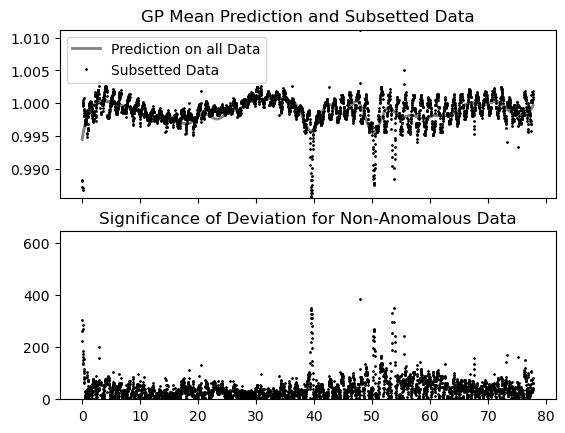


 New dip identified at anomalous index 1793, x[index] = 39.510416666666664
Old ln-likelihood: -1000000.00000
New ln-likelihood: 3.66933
Difference in ln-likelihood: 1000003.66933
Anomaly index 2, left_edge:right_edge 1792:1793


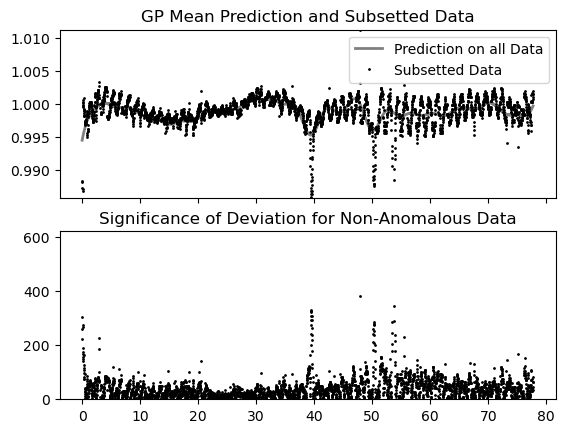

Old ln-likelihood: 3.66933
New ln-likelihood: 3.66996
Difference in ln-likelihood: 0.00064
Anomaly index 2, left_edge:right_edge 1792:1794


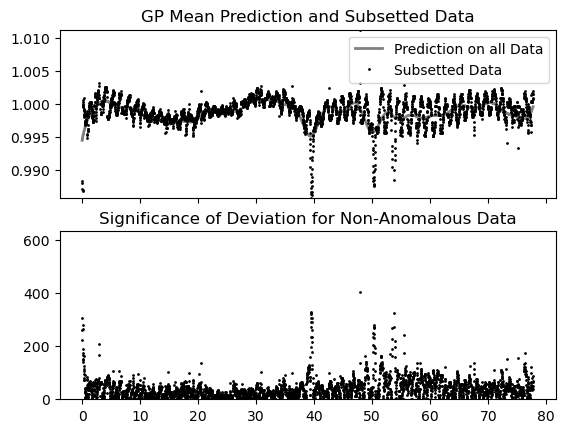

Old ln-likelihood: 3.66996
New ln-likelihood: 3.67031
Difference in ln-likelihood: 0.00034
Anomaly index 2, left_edge:right_edge 1791:1794


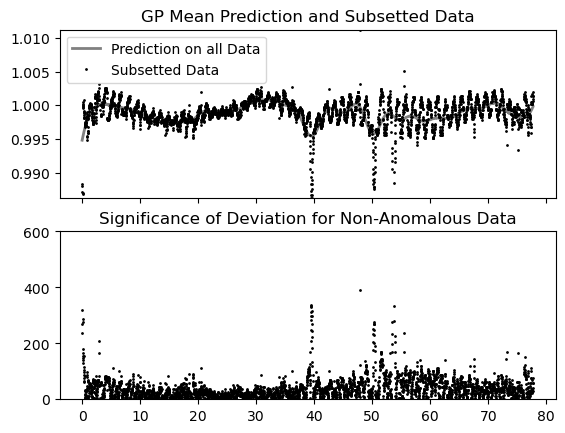

Old ln-likelihood: 3.67031
New ln-likelihood: 3.67024
Difference in ln-likelihood: -0.00007
Anomaly index 2, left_edge:right_edge 1791:1795


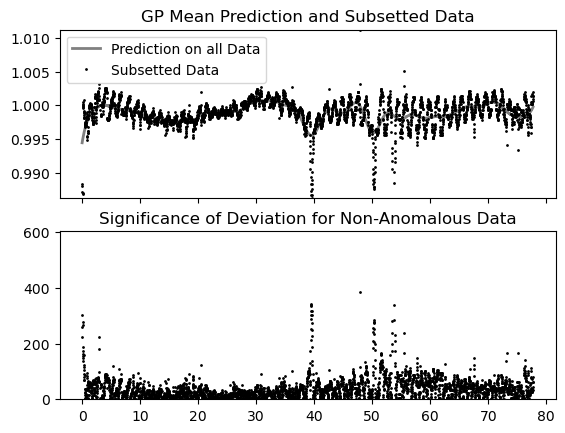

Old ln-likelihood: 3.67024
New ln-likelihood: 3.67039
Difference in ln-likelihood: 0.00015
Anomaly index 2, left_edge:right_edge 1790:1795


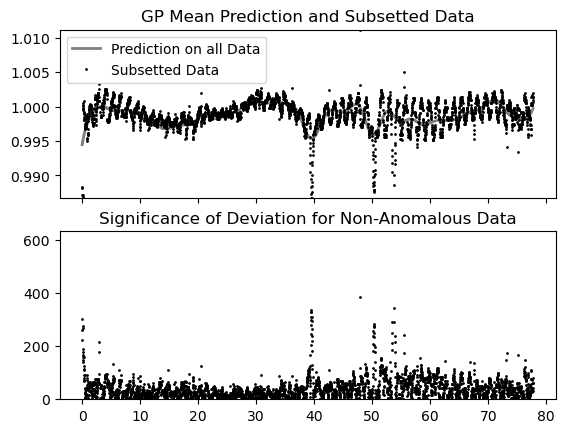

Old ln-likelihood: 3.67039
New ln-likelihood: 3.67029
Difference in ln-likelihood: -0.00010
Anomaly index 2, left_edge:right_edge 1790:1796


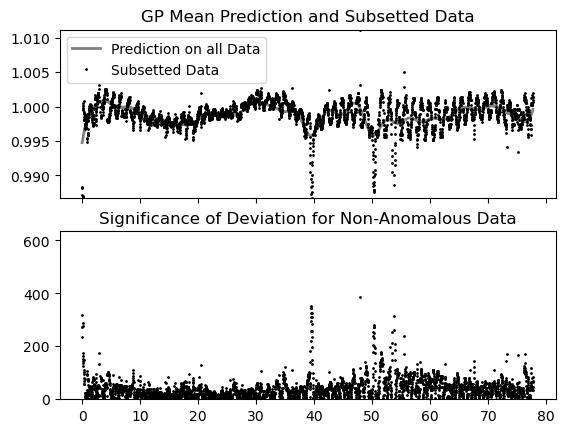

Old ln-likelihood: 3.67029
New ln-likelihood: 3.67043
Difference in ln-likelihood: 0.00014
Anomaly index 2, left_edge:right_edge 1789:1796


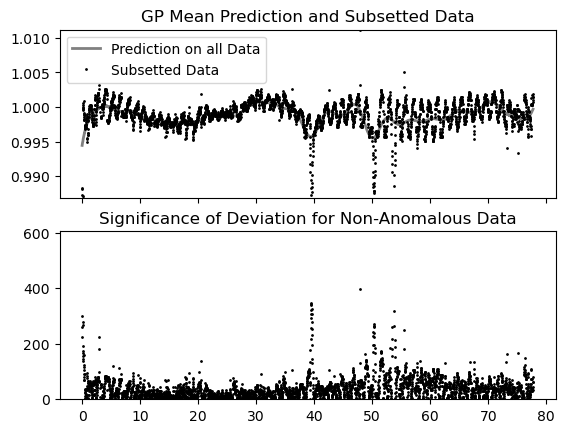

Old ln-likelihood: 3.67043
New ln-likelihood: 3.67085
Difference in ln-likelihood: 0.00042
Anomaly index 2, left_edge:right_edge 1789:1797


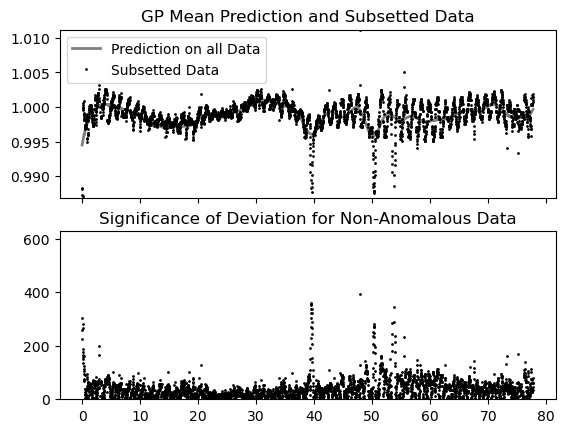

Old ln-likelihood: 3.67085
New ln-likelihood: 3.67093
Difference in ln-likelihood: 0.00008
Anomaly index 2, left_edge:right_edge 1788:1797


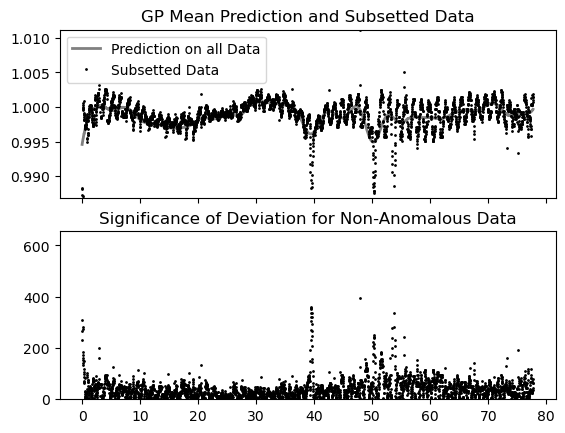

Old ln-likelihood: 3.67093
New ln-likelihood: 3.67098
Difference in ln-likelihood: 0.00005
Anomaly index 2, left_edge:right_edge 1788:1798


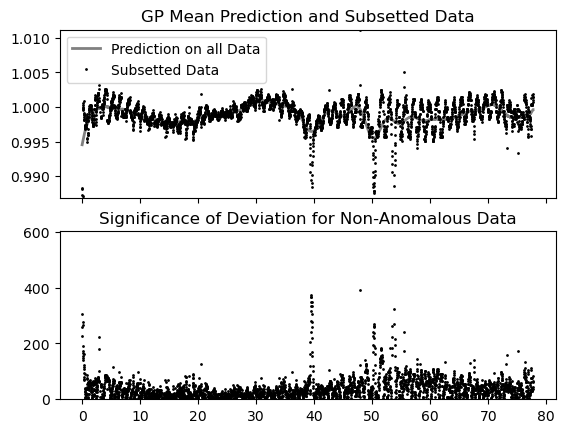

Old ln-likelihood: 3.67098
New ln-likelihood: 3.67100
Difference in ln-likelihood: 0.00002
Anomaly index 2, left_edge:right_edge 1787:1798


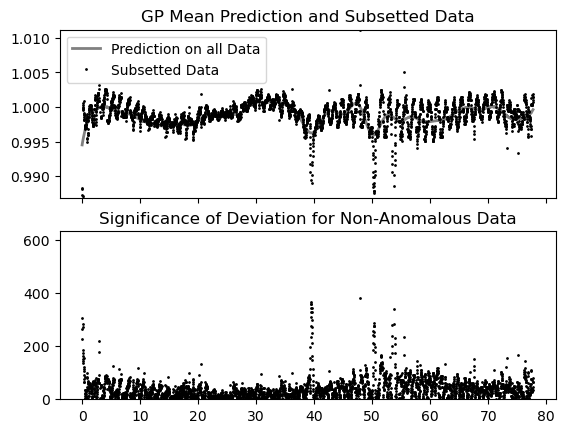

Old ln-likelihood: 3.67100
New ln-likelihood: 3.67124
Difference in ln-likelihood: 0.00024
Anomaly index 2, left_edge:right_edge 1787:1799


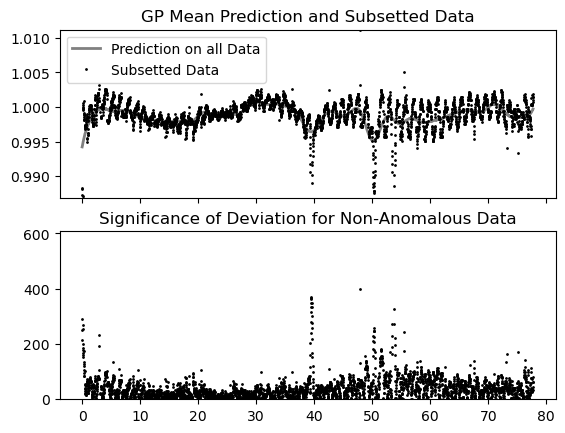

Old ln-likelihood: 3.67124
New ln-likelihood: 3.67118
Difference in ln-likelihood: -0.00006
Anomaly index 2, left_edge:right_edge 1786:1799


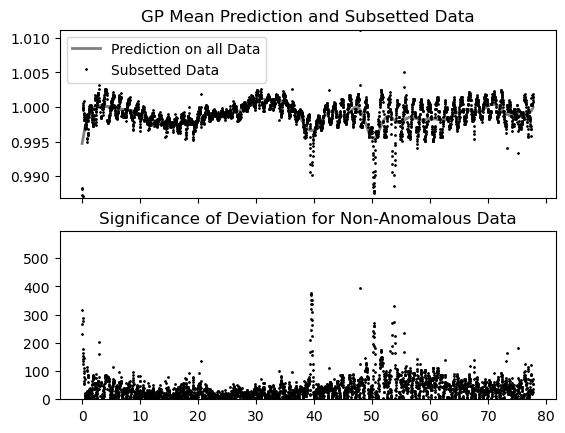

Old ln-likelihood: 3.67118
New ln-likelihood: 3.67127
Difference in ln-likelihood: 0.00009
Anomaly index 2, left_edge:right_edge 1786:1800


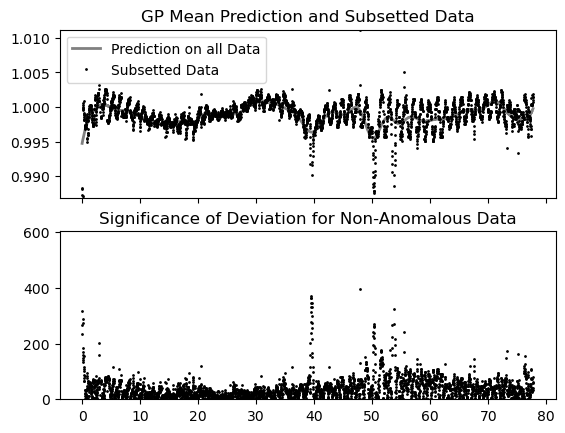

Old ln-likelihood: 3.67127
New ln-likelihood: 3.67066
Difference in ln-likelihood: -0.00061
Anomaly index 2, left_edge:right_edge 1785:1800


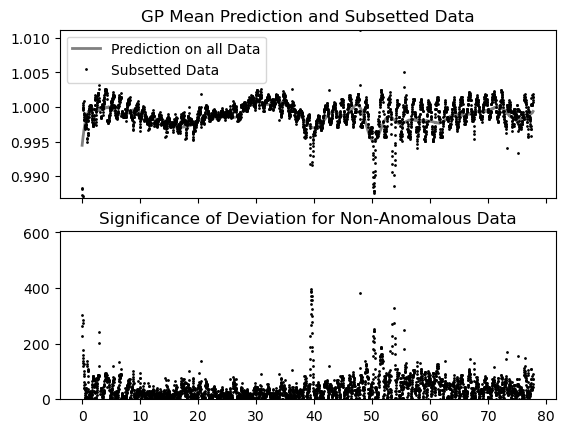


 New dip identified at anomalous index 2399, x[index] = 53.05208333333333
Old ln-likelihood: -1000000.00000
New ln-likelihood: 3.67084
Difference in ln-likelihood: 1000003.67084
Anomaly index 3, left_edge:right_edge 2398:2399


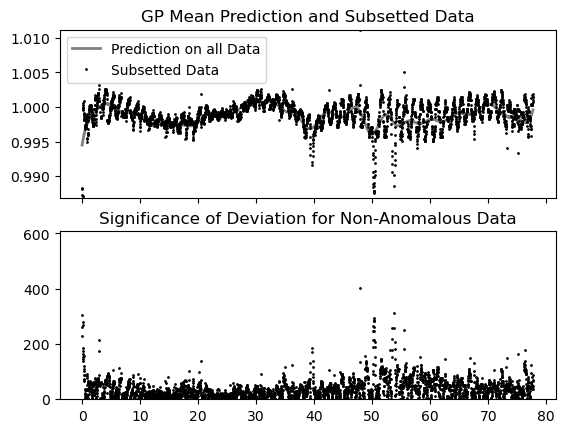

Old ln-likelihood: 3.67084
New ln-likelihood: 3.67149
Difference in ln-likelihood: 0.00065
Anomaly index 3, left_edge:right_edge 2398:2400


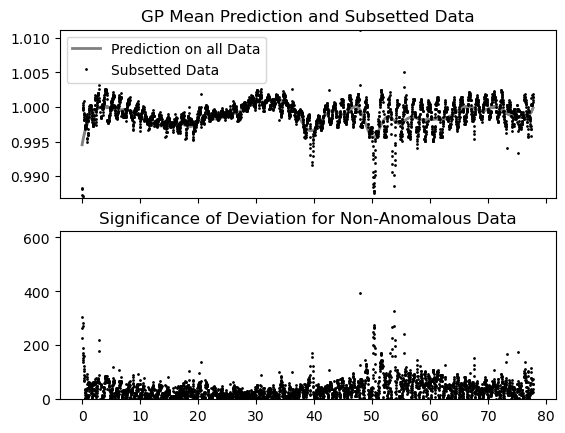

Old ln-likelihood: 3.67149
New ln-likelihood: 3.67114
Difference in ln-likelihood: -0.00035
Anomaly index 3, left_edge:right_edge 2397:2400


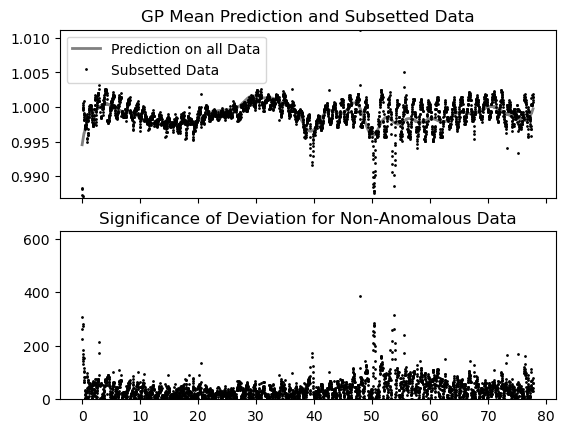

Old ln-likelihood: 3.67114
New ln-likelihood: 3.67150
Difference in ln-likelihood: 0.00036
Anomaly index 3, left_edge:right_edge 2397:2401


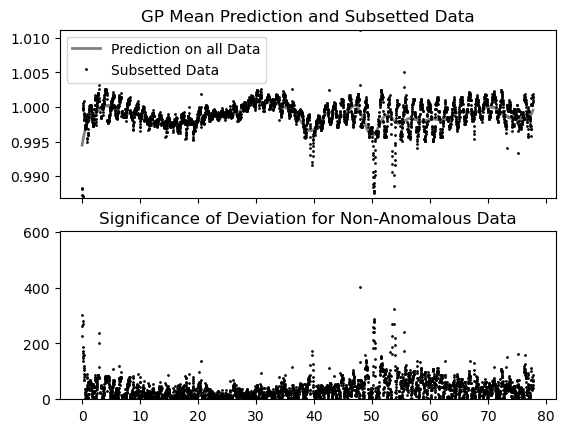

Old ln-likelihood: 3.67150
New ln-likelihood: 3.67083
Difference in ln-likelihood: -0.00067
Anomaly index 3, left_edge:right_edge 2396:2401


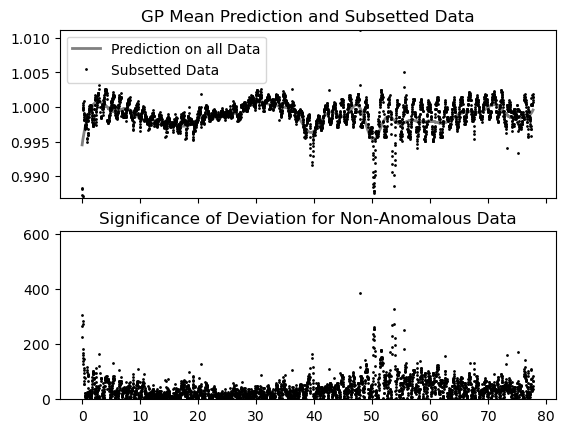


 New dip identified at anomalous index 0, x[index] = 0.010416666666666666
Old ln-likelihood: -1000000.00000
New ln-likelihood: 3.67173
Difference in ln-likelihood: 1000003.67173
Anomaly index 4, left_edge:right_edge -1:0


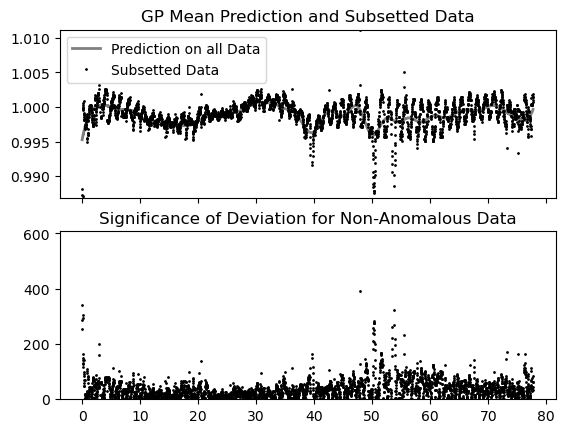

Old ln-likelihood: 3.67173
New ln-likelihood: 3.67150
Difference in ln-likelihood: -0.00023
Anomaly index 4, left_edge:right_edge -1:1


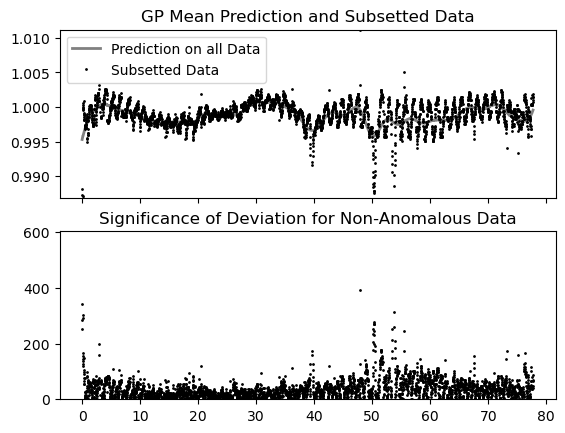

Old ln-likelihood: 3.67150
New ln-likelihood: 3.67123
Difference in ln-likelihood: -0.00027
Anomaly index 4, left_edge:right_edge -2:1


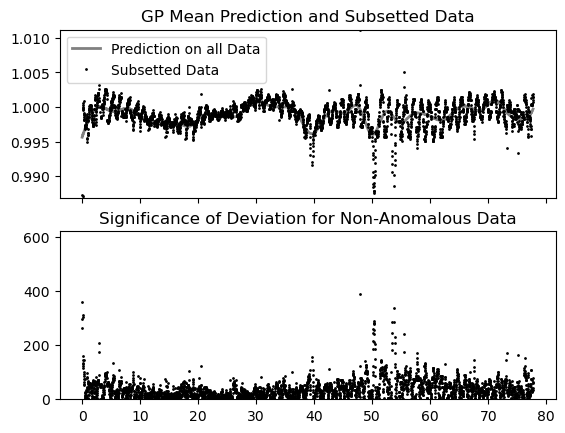

Old ln-likelihood: 3.67123
New ln-likelihood: 3.67158
Difference in ln-likelihood: 0.00035
Anomaly index 4, left_edge:right_edge -2:2


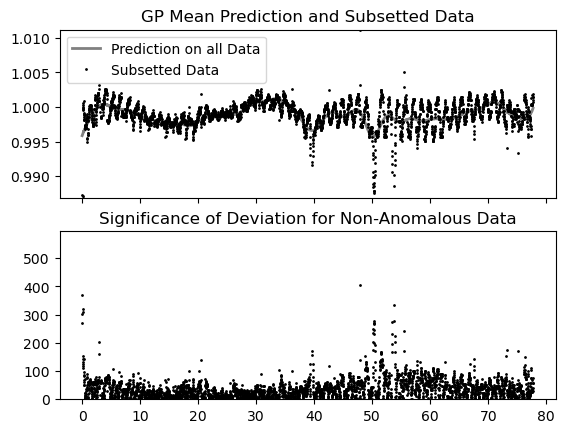

Old ln-likelihood: 3.67158
New ln-likelihood: 3.67195
Difference in ln-likelihood: 0.00037
Anomaly index 4, left_edge:right_edge -3:2


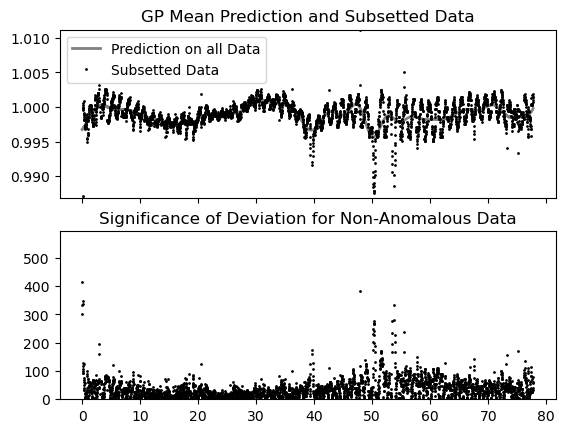

Old ln-likelihood: 3.67195
New ln-likelihood: 3.67161
Difference in ln-likelihood: -0.00034
Anomaly index 4, left_edge:right_edge -3:3


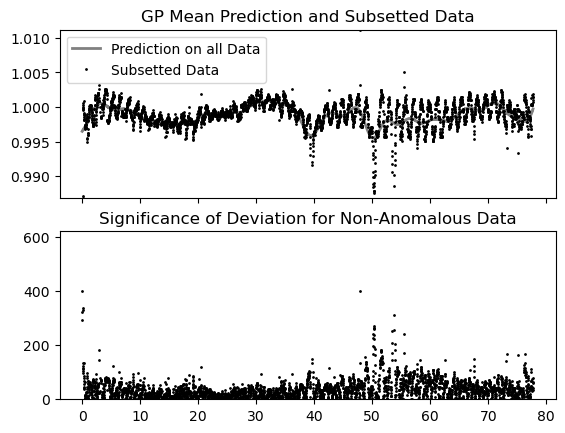

Old ln-likelihood: 3.67161
New ln-likelihood: 3.67221
Difference in ln-likelihood: 0.00060
Anomaly index 4, left_edge:right_edge -4:3


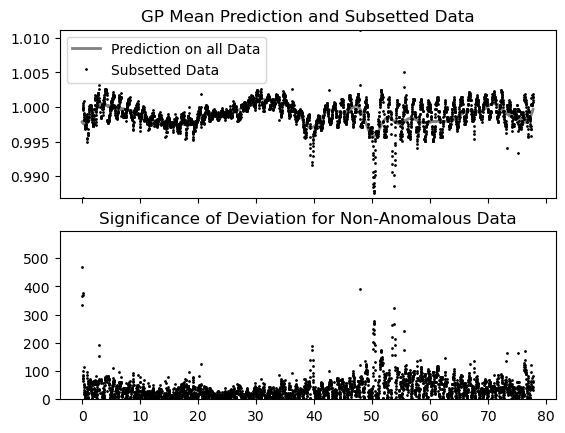

Old ln-likelihood: 3.67221
New ln-likelihood: 3.67193
Difference in ln-likelihood: -0.00028
Anomaly index 4, left_edge:right_edge -4:4


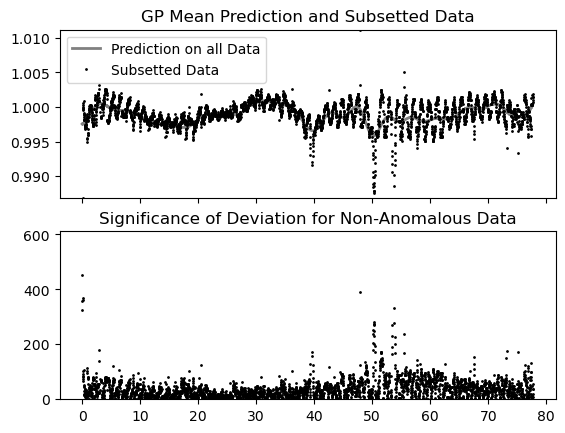

Old ln-likelihood: 3.67193
New ln-likelihood: 3.67189
Difference in ln-likelihood: -0.00004
Anomaly index 4, left_edge:right_edge -5:4


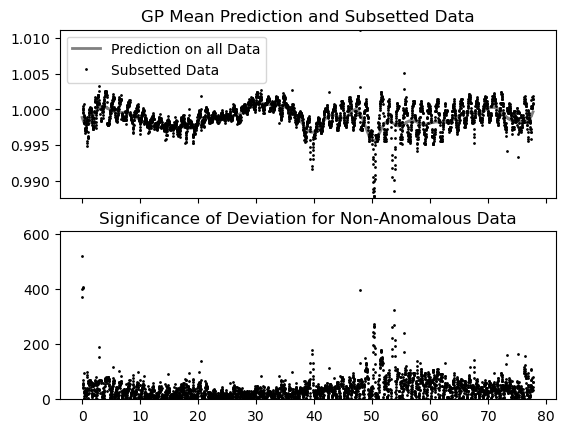

Old ln-likelihood: 3.67189
New ln-likelihood: 3.67215
Difference in ln-likelihood: 0.00026
Anomaly index 4, left_edge:right_edge -5:5


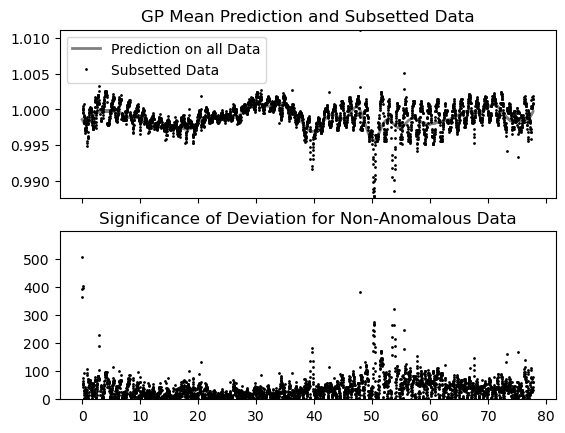

Old ln-likelihood: 3.67215
New ln-likelihood: 3.67197
Difference in ln-likelihood: -0.00017
Anomaly index 4, left_edge:right_edge -6:5


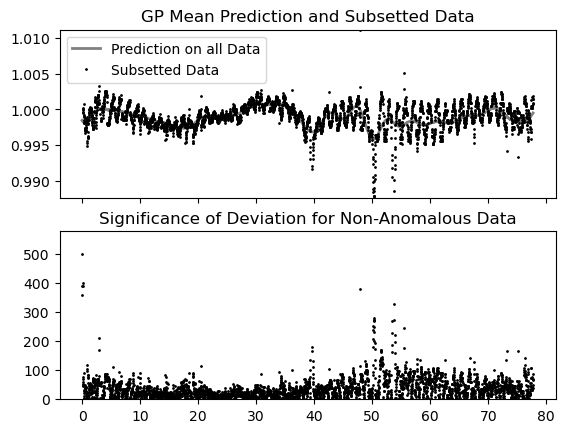

Old ln-likelihood: 3.67197
New ln-likelihood: 3.67161
Difference in ln-likelihood: -0.00036
Anomaly index 4, left_edge:right_edge -6:6


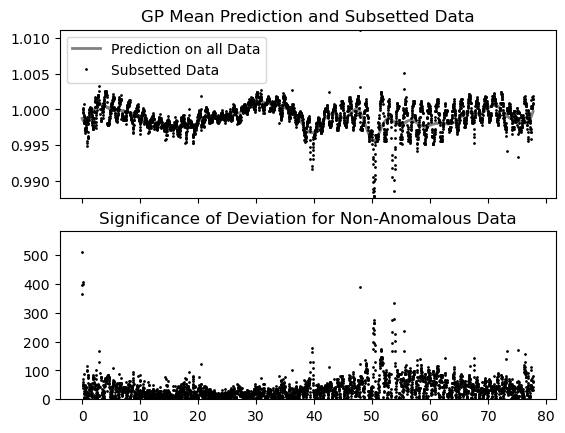

Old ln-likelihood: 3.67161
New ln-likelihood: 3.67187
Difference in ln-likelihood: 0.00026
Anomaly index 4, left_edge:right_edge -7:6


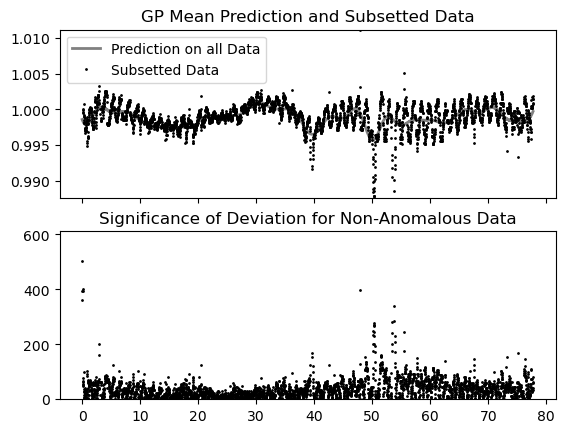

Old ln-likelihood: 3.67187
New ln-likelihood: 3.67190
Difference in ln-likelihood: 0.00003
Anomaly index 4, left_edge:right_edge -7:7


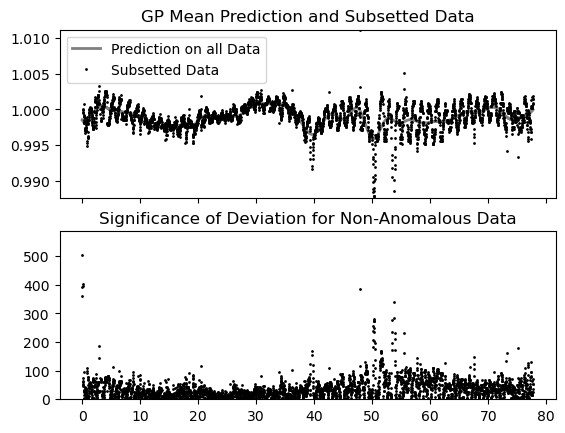

Old ln-likelihood: 3.67190
New ln-likelihood: 3.67224
Difference in ln-likelihood: 0.00034
Anomaly index 4, left_edge:right_edge -8:7


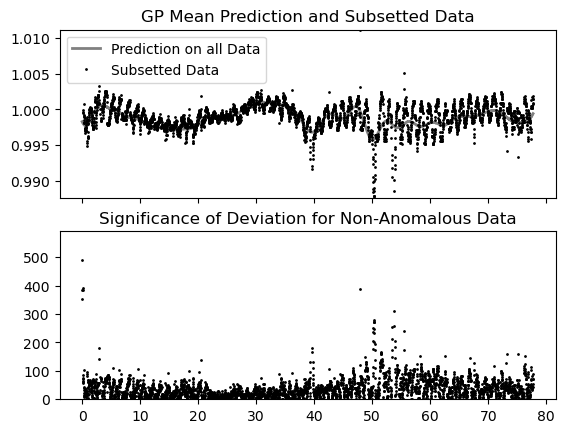

Old ln-likelihood: 3.67224
New ln-likelihood: 3.67167
Difference in ln-likelihood: -0.00057
Anomaly index 4, left_edge:right_edge -8:8


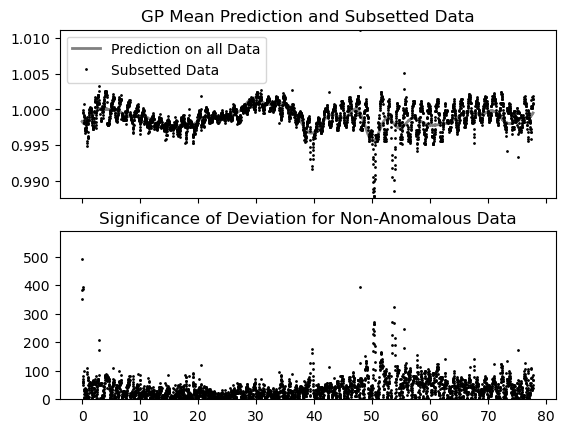

In [117]:
# Hyperparameters
num_anomalies = 5
num_steps = len(x)
anomalous = np.zeros(num_steps) # 0 means non-anomalous, 1 means anomalous at that time step

# Step 7 (repeat for every anomaly)
for i in range(num_anomalies):
    # Get subset of data that is flagged an non-anomalous
    x_sub = torch.tensor(x[anomalous == 0], dtype=torch.float32).to(device)
    y_sub = torch.tensor(y[anomalous == 0], dtype=torch.float32).to(device)
    y_err_sub = torch.tensor(y_err[anomalous == 0], dtype=torch.float32).to(device)
    
    # Train GP model
    model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, device=device)

    # Predict
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x_tensor))
        pred_mean = observed_pred.mean.cpu().numpy()
        pred_var = observed_pred.variance.cpu().numpy()

    # Find index of largest deviation
    sig_dev = (pred_mean - y) / y_err
    index = np.argmax(sig_dev[anomalous == 0])
    print(f"\n New dip identified at anomalous index {index}, x[index] = {x[index]}")
    diff_loglike = 1e6
    left_edge = index
    right_edge = index
    flag = 1
    loglike = -1e6
    
    # While the marginal log likelihood is increasing, expand the anomalous edges
    while diff_loglike > -5e-4: # Tune this: original code was 1.02, far too large for K2 data
        # Subset x, y, and y_err
        subset = (((np.arange(len(x)) > right_edge) | (np.arange(len(x)) < left_edge)) & (anomalous == 0))
        x_sub = torch.tensor(x[subset], dtype=torch.float32).to(device)
        y_sub = torch.tensor(y[subset], dtype=torch.float32).to(device)
        y_err_sub = torch.tensor(y_err[subset], dtype=torch.float32).to(device)
        
        # Re-train the GP on non-anomalous data
        model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, device=device)

        # Calculate loglikelihood difference
        old_loglike = loglike
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            output = model(x_sub)
            loglike = mll(output, y_sub).item()
        
        diff_loglike = loglike - old_loglike
        print(f"Old ln-likelihood: {old_loglike:.5f}")
        print(f"New ln-likelihood: {loglike:.5f}")
        print(f"Difference in ln-likelihood: {diff_loglike:.5f}")

        # Expand anomalous region
        if flag == 1:
            left_edge = left_edge - 1
        else:
            right_edge = right_edge + 1

        flag = -1 * flag
        print(f"Anomaly index {i}, left_edge:right_edge {left_edge}:{right_edge}")
        
        # Predict on full dataset
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(x_tensor))
            pred_mean = observed_pred.mean.cpu().numpy()
            pred_var = observed_pred.variance.cpu().numpy()

        # Plot
        fig, axs = plt.subplots(2, 1, sharex=True)
        axs[0].set_title("GP Mean Prediction and Subsetted Data")
        axs[0].plot(x, pred_mean, "grey", lw=2, label="Prediction on all Data")
        axs[0].plot(x_sub.cpu().numpy(), y_sub.cpu().numpy(), '.k', markersize=2, label="Subsetted Data")
        axs[0].set_ylim(np.min(y_sub.cpu().numpy()), np.max(y_sub.cpu().numpy()))
        axs[0].legend()

        sig_dev = (pred_mean - y) / y_err
        axs[1].set_title("Significance of Deviation for Non-Anomalous Data")
        axs[1].plot(x[anomalous == 0], np.abs(sig_dev[anomalous == 0]), '.k', markersize=2)
        axs[1].set_ylim(0, 20 * np.median(np.abs(sig_dev[anomalous == 0])))
        plt.show(block=False)
        plt.pause(1)
        plt.close()

    # Update anomalous array
    y[left_edge:right_edge + 1] = pred_mean[left_edge:right_edge + 1]
    anomalous[left_edge:right_edge + 1] = 1

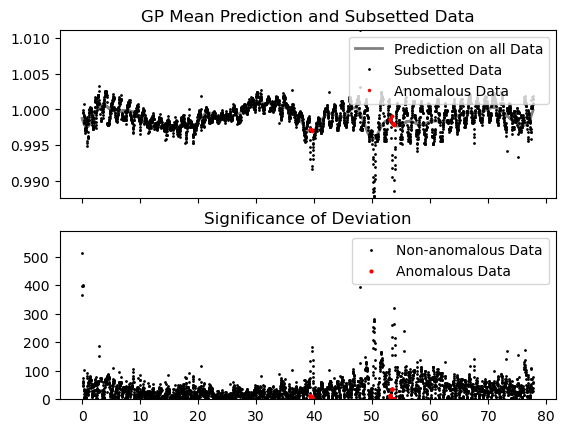

In [118]:
# Train on final subset
model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, device=device)

# Predict
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_tensor))
    pred_mean = observed_pred.mean.cpu().numpy()
    pred_var = observed_pred.variance.cpu().numpy()

# Plot
fig, axs = plt.subplots(2,1,sharex=True)
axs[0].set_title("GP Mean Prediction and Subsetted Data")
axs[0].plot(x, pred_mean, "grey", lw=2, label="Prediction on all Data")
axs[0].plot(x_sub.cpu().numpy(), y_sub.cpu().numpy(), '.k', markersize=2, label="Subsetted Data")
axs[0].set_ylim(np.min(y_sub.cpu().numpy()), np.max(y_sub.cpu().numpy()))
axs[0].plot(x[(anomalous==1)], y[(anomalous==1)],'.r',markersize=3, label="Anomalous Data")
axs[0].legend()

sigdev = (pred_mean - y) / y_err
axs[1].set_title("Significance of Deviation")
axs[1].plot(x[(anomalous==0)], np.abs(sigdev[(anomalous==0)]), '.k', markersize=2, label="Non-anomalous Data")
axs[1].plot(x[(anomalous==1)], np.abs(sigdev[(anomalous==1)]), '.r', markersize=4, label="Anomalous Data")
axs[1].set_ylim(0, 20 * np.median(np.abs(sigdev[(anomalous==0)])))
axs[1].legend()
# plt.savefig('tess_gp.pdf')
plt.show(block=True)